In [12]:
include("State_Space_Model.jl")
using .state_space_model

include("Kalman.jl")
using .kalman

include("MCMC.jl")
using .MCMC

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots
using ProgressMeter


In [13]:
# Parameters in θ
θ_elements = ["ρ", "λ_c", "σ²_ε, y", "σ²_ξ, y", "σ²_κ, y"]
n_params = length(θ_elements)

# Create the support matrix
support = repeat([0.0 3.0], n_params, 1)
support[1, 2] = 1.0
println("Support:", support)

# Create the prior distributions
prior_distributions = fill("uniform", n_params)
println("Prior distributions: ", prior_distributions)

# Create the prior hyperparameters matrix
prior_hyperparameters = repeat([0.0 3.0], n_params, 1)
prior_hyperparameters[1, 2] = 1.0
println("Prior hyperparameters:", prior_hyperparameters)

# Combine into a named tuple
prior_info = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters,
)


# True parameters
ρ = 0.6
λ_c = 1.5
σ²_ε_y = 0.5
σ²_ξ_y = 0.7
σ²_κ_y = 0.3

θ_true = [ρ, λ_c, σ²_ε_y, σ²_ξ_y, σ²_κ_y]

# cycle_order
cycle_order = 2


#States in α
α_elements = [
    "u_t^y", 
    "β_t^y", 
    "ψ_{2,t}^y", 
    "ψ_{2,t}^{y*}", 
    "ψ_{1,t}^y", 
    "ψ_{1,t}^{y*}", 
]

Support:[0.0 1.0; 0.0 3.0; 0.0 3.0; 0.0 3.0; 0.0 3.0]
Prior distributions: ["uniform", "uniform", "uniform", "uniform", "uniform"]
Prior hyperparameters:[0.0 1.0; 0.0 3.0; 0.0 3.0; 0.0 3.0; 0.0 3.0]


6-element Vector{String}:
 "u_t^y"
 "β_t^y"
 "ψ_{2,t}^y"
 "ψ_{2,t}^{y*}"
 "ψ_{1,t}^y"
 "ψ_{1,t}^{y*}"

In [14]:
Z,H,T,R,Q,P_diffuse = state_space(θ_true, cycle_order)
println("Z = ", Z)
println("H = ", H)
println("T = ", T)
println("R = ", R)
println("Q = ", Q)
println("P_diffuse = ", P_diffuse)

# Print shapes
println("Z shape: ", size(Z))
println("H shape: ", size(H))
println("T shape: ", size(T))
println("R shape: ", size(R))
println("Q shape: ", size(Q))
println("P_diffuse shape: ", size(P_diffuse))

Z = [1.0 0.0 1.0 0.0 0.0 0.0]
H = [0.5]
T = [1.0 1.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.042442321000621744 0.5984969919624327 1.0 0.0; 0.0 0.0 -0.5984969919624327 0.042442321000621744 0.0 1.0; 0.0 0.0 0.0 0.0 0.042442321000621744 0.5984969919624327; 0.0 0.0 0.0 0.0 -0.5984969919624327 0.042442321000621744]
R = [0.0 0.0 0.0; 1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
Q = [0.7 0.0 0.0; 0.0 0.3 0.0; 0.0 0.0 0.3]
P_diffuse = [1.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0]
Z shape: (1, 6)
H shape: (1,)
T shape: (6, 6)
R shape: (6, 3)
Q shape: (3, 3)
P_diffuse shape: (6, 6)


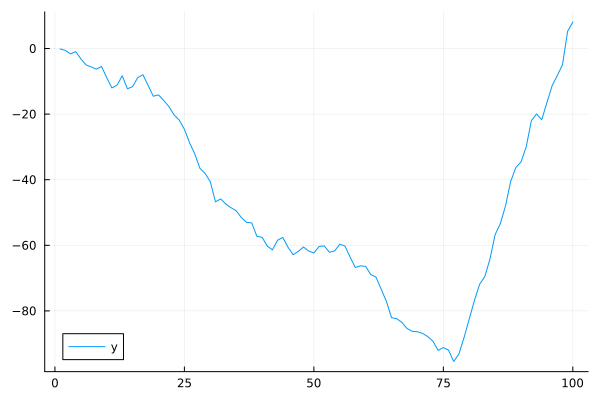

shape of obs = (100, 1)
shape of α = (100, 6)


6×6 Matrix{Bool}:
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  1  0  0  0
 0  0  0  1  0  0
 0  0  0  0  1  0
 0  0  0  0  0  1

In [15]:
n_obs = 100

#simulate data
obs, α = simulate_data(θ_true, cycle_order, n_obs)

# shape of obs
println("shape of obs = ", size(obs))
# shape of α
println("shape of α = ", size(α))

y = obs[:,1]


# plot data
plot(y, label="y")
display(plot!())

α0 = zeros(size(T, 1))
P0 = Matrix(I, size(T, 1), size(T, 1))  # large initial uncertainty



## MCMC

In [16]:
θ_chain, θ_chain_init, α_draws = MCMC_estimation(y, prior_info, α0, P0, cycle_order;
 iter_init = 25000, 
 burn_init = 15000,
 iter_rec = 25000,
burn_rec = 15000,
θ_init = θ_true,
ω = 0.1)

Initialization Phase 100%|███████████████████████████████| Time: 0:00:10


Initialization Acceptance Rate: 30.672%


Recursion Phase 100%|████████████████████████████████████| Time: 0:00:24


Recursion Acceptance Rate: 32.496%


([0.6109070365443537 1.535435965533755 … 0.9405979341586919 0.38728310241287; 0.6109070365443537 1.535435965533755 … 0.9405979341586919 0.38728310241287; … ; 0.6429734072328516 1.2849333313774867 … 0.7348738045956922 0.2955389705114212; 0.6429734072328516 1.2849333313774867 … 0.7348738045956922 0.2955389705114212], [0.5999999999999999 1.5 … 0.7000000000000002 0.29999999999999993; 0.5999999999999999 1.5 … 0.7000000000000002 0.29999999999999993; … ; 0.4428588107366852 1.2674366603081852 … 0.865624908559182 0.6343887388161152; 0.4428588107366852 1.2674366603081852 … 0.865624908559182 0.6343887388161152], [0.3109801799515072 0.7972398392667045 … 2.5340419222123955 6.991613123893842; 0.39267557748108084 0.4156539235496789 … 3.837642697146549 9.770613953083654; … ; 0.7666712201464332 -0.6907188878487793 … 2.1572793969597797 8.098501263351295; 0.5746592991082063 0.47572079875761564 … 2.876512898370123 7.576534373624952;;; 0.4862596593151973 -1.4644793558007085 … 4.457571201681461 3.6611804734

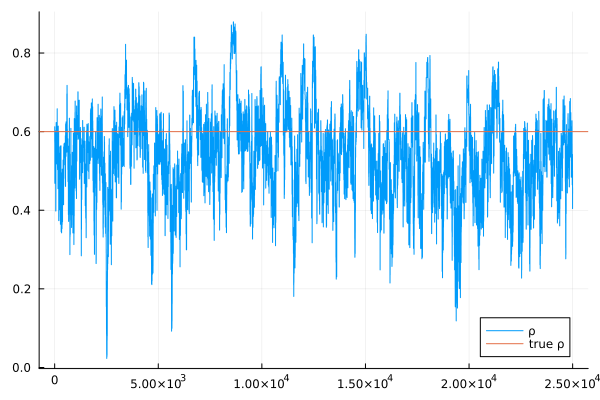

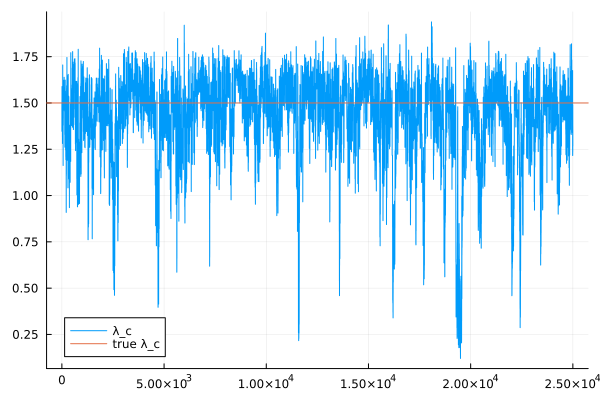

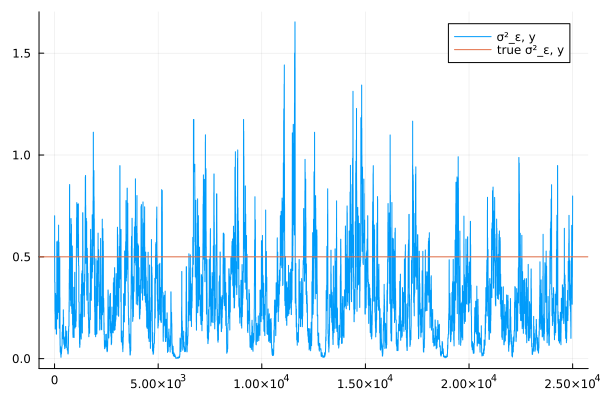

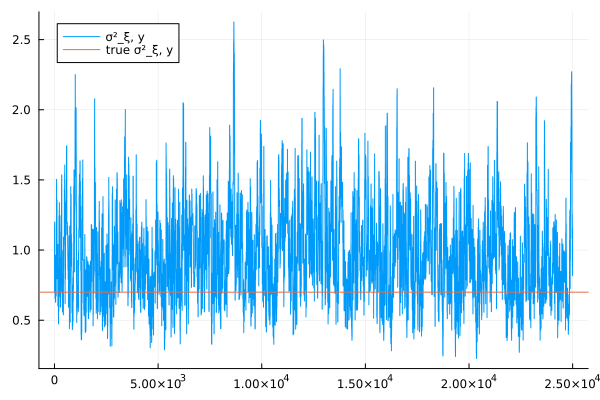

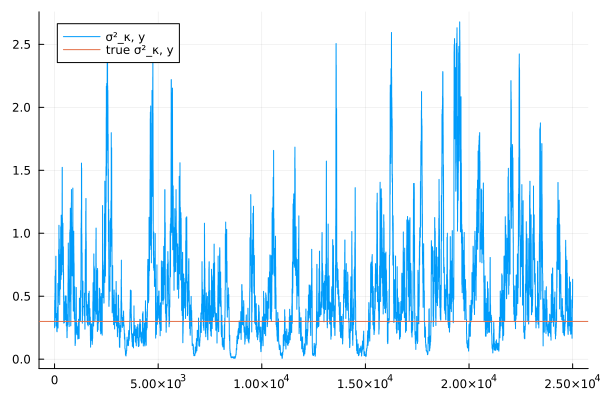

Initial chain shape: (25000, 5)


In [17]:
println("Initial chain shape: ", size(θ_chain_init))
#Print trace plot and add true value
for i in 1:size(θ_chain_init, 2)
    plot(θ_chain_init[:,i], label="$(θ_elements[i])")
    hline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end

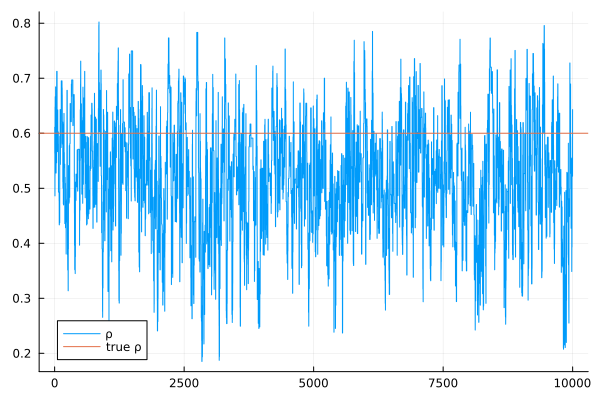

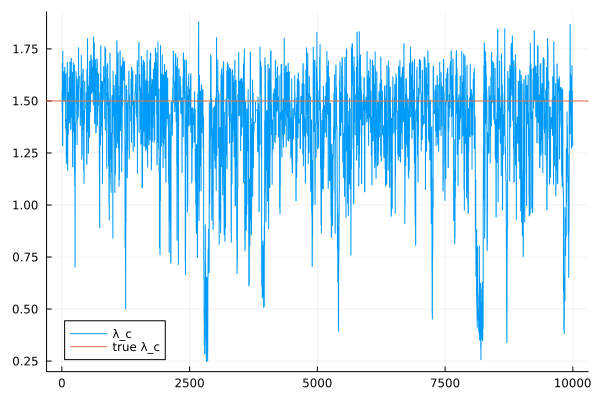

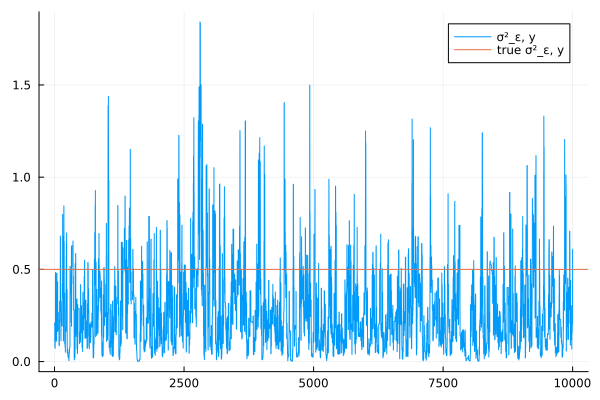

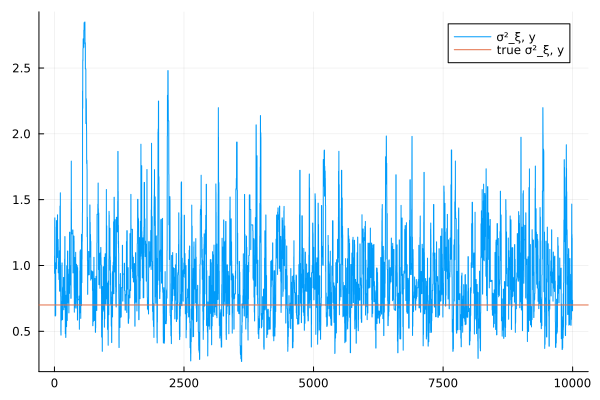

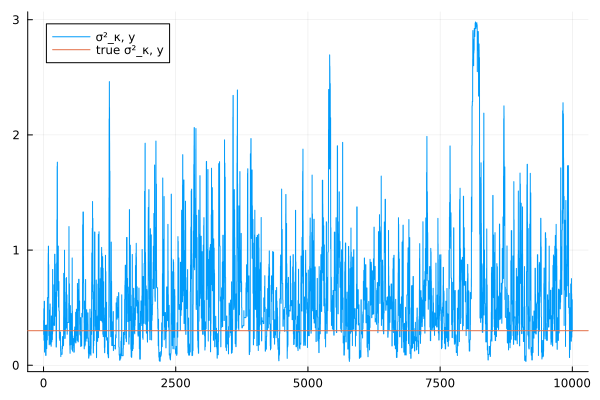

Rec chain shape: (10000, 5)


In [18]:
println("Rec chain shape: ", size(θ_chain))

#Print trace plot and add true value
for i in 1:size(θ_chain, 2)
    plot(θ_chain[:,i], label="$(θ_elements[i])")
    hline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end



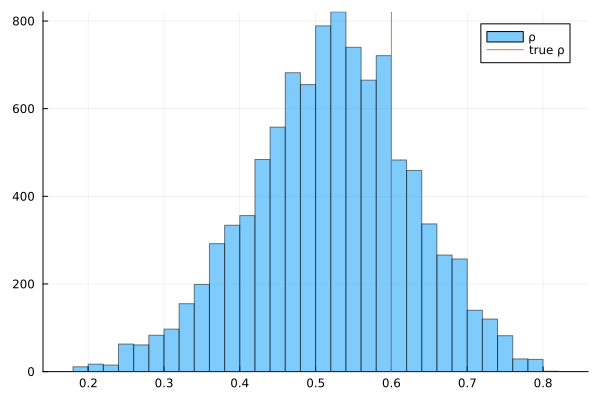

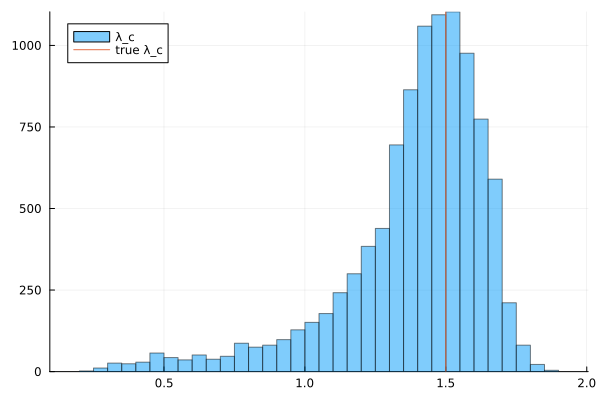

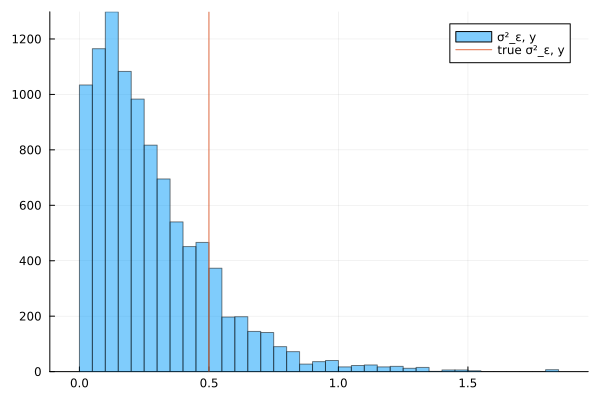

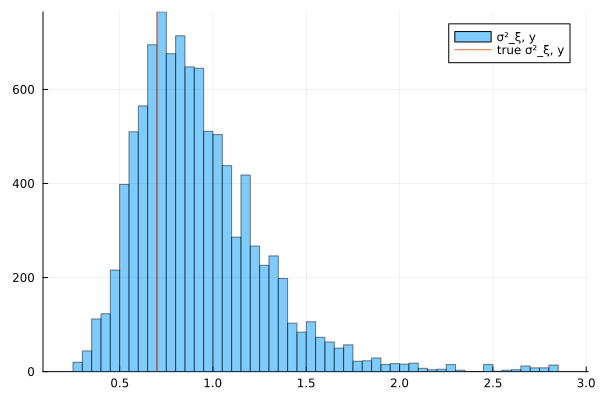

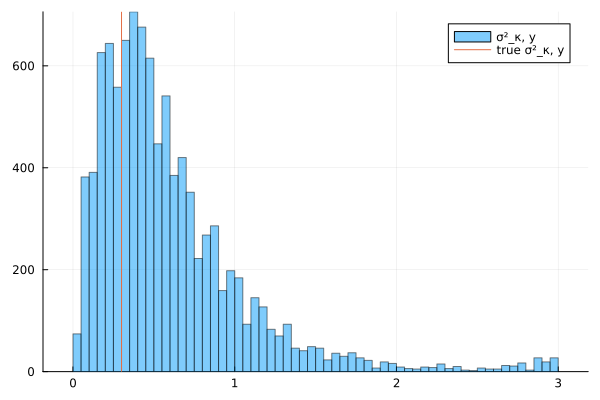

In [19]:
# plot histograms of the chains and add line at true value
for i in 1:size(θ_chain, 2)
    histogram(θ_chain[:,i], label="$(θ_elements[i])", alpha=0.5)
    vline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end

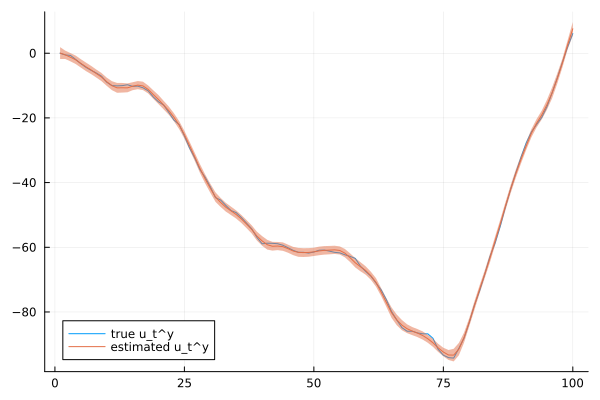

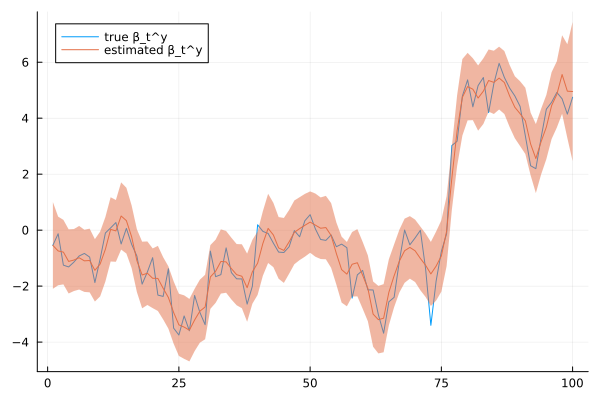

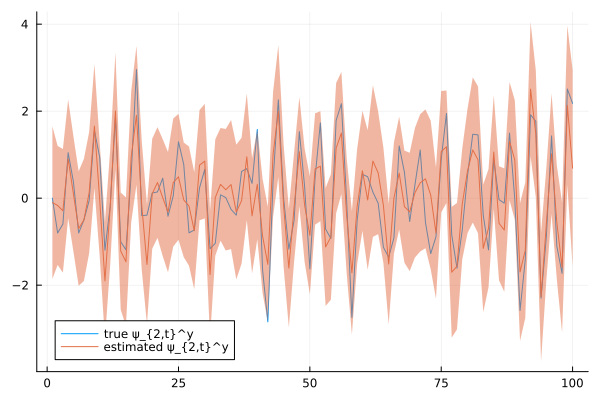

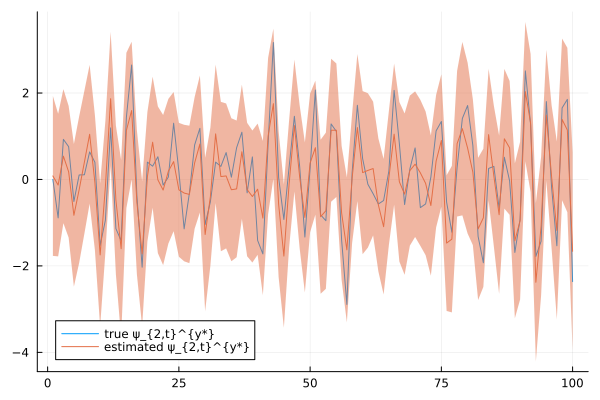

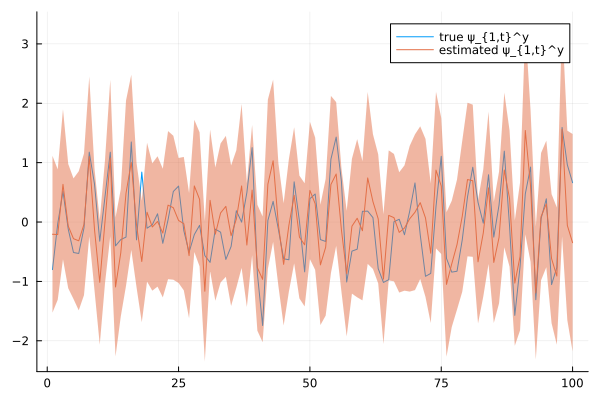

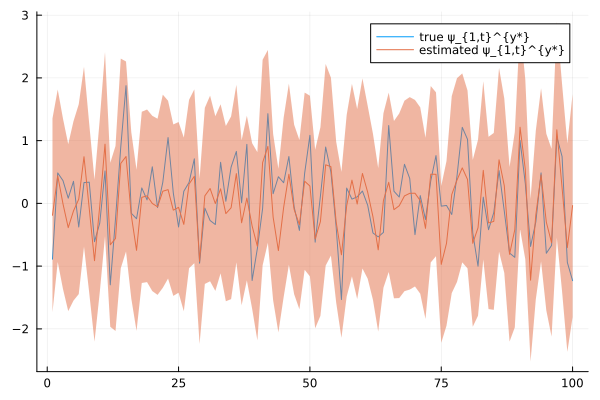

Mean of α_draws: (1, 100, 6)


In [20]:
# Compute the mean over iterations (dimension 1)
α_mean = mean(α_draws, dims=1)
println("Mean of α_draws: ", size(α_mean))

# Compute the 2.5% and 97.5% quantiles 
α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)



# Plot true states, mean of states, and confidence intervals of states
for i in 1:size(α_mean, 3)
    plot(α[:, i], label="true $(α_elements[i])")
    plot!(α_mean[1, :, i], ribbon=(α_ci[2, :, i] .- α_mean[1, :, i]), label="estimated $(α_elements[i])")
    display(plot!())
end


## MLE

In [21]:
using Optim


lower_bounds = [0.0, 0.0, 1e-6, 1e-6, 1e-6]
upper_bounds = [1.0, 3.0, 3.0, 3.0, 3.0]
θ_init = [0.5, 1.0, 0.8, 0.8, 0.8]

objective(θ) = neg_log_likelihood(θ, y, α0, P0, cycle_order)
res = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(BFGS()))
θ_est = Optim.minimizer(res)

# Print the results:
println("MLE Results (with bounded optimization):")
for (i, param_name) in enumerate(θ_elements)
    println("Estimated $(param_name): $(θ_est[i])   (True value: $(θ_true[i]))")
end
println("Final negative log-likelihood: ", Optim.minimum(res))


MLE Results (with bounded optimization):
Estimated ρ: 0.5779312314237126   (True value: 0.6)
Estimated λ_c: 1.5316412034586544   (True value: 1.5)
Estimated σ²_ε, y: 0.17246481805500707   (True value: 0.5)
Estimated σ²_ξ, y: 0.8626835343302204   (True value: 0.7)
Estimated σ²_κ, y: 0.3179608455917067   (True value: 0.3)
Final negative log-likelihood: 217.86512114708214


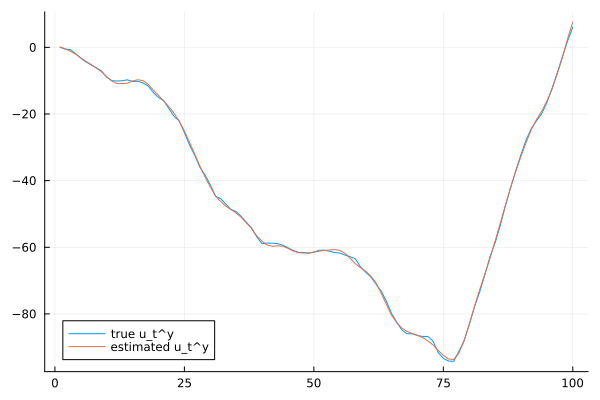

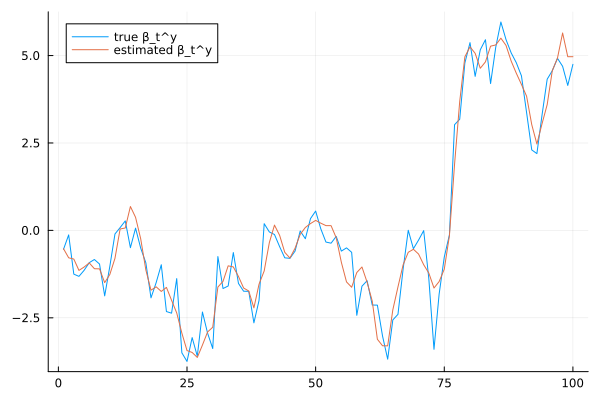

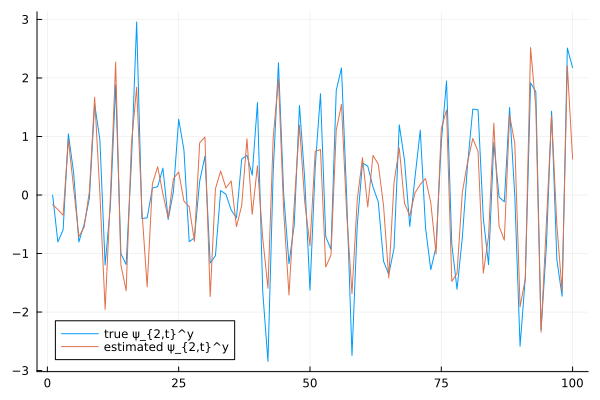

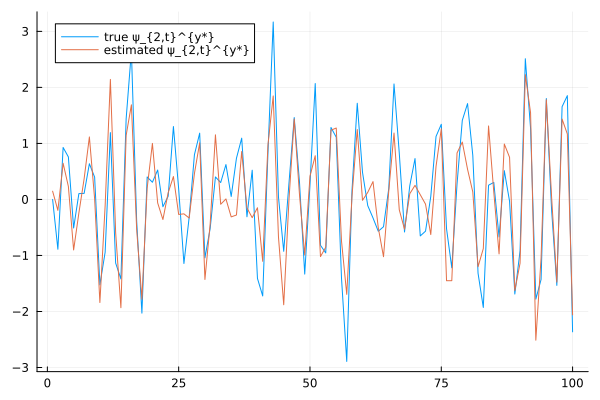

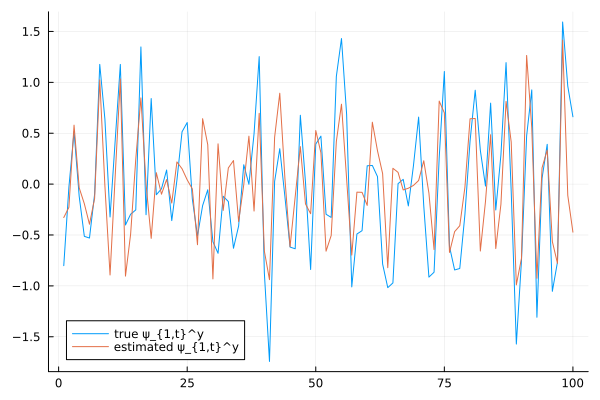

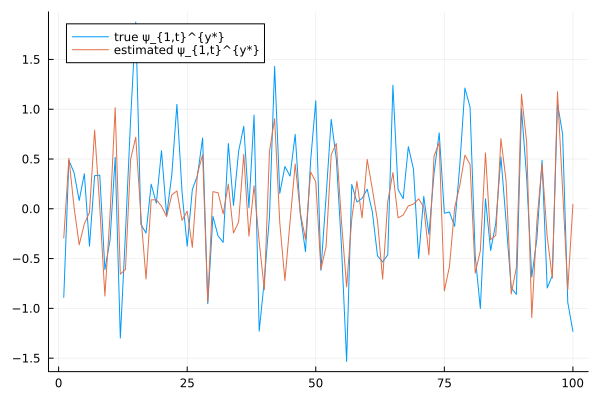

In [22]:
# estimate states
LogL_diff, α_diff, P_diff = diffuse_kalman_filter(obs, θ_est, α0, P0, cycle_order, true, false)

#plot estimated states and true states
for i in 1:size(α,2)
    plot(α[:,i], label="true $(α_elements[i])")
    plot!(α_diff[:,i], label="estimated $(α_elements[i])")
    display(plot!())
end

